In [1]:
import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("../data/maier_spitzer_fil_log_pvals_scaled_train.csv", index_col=0)

#--Trasforming
cutoff = 0.375
df = df > cutoff

uneffective = df.index.values[np.array(df.sum(1) == 0)]
df = df.iloc[np.array(df.sum(1) > 0)]

print('# uneffective: %i'%len(uneffective))
print('# effective: %i'%len(df))

# uneffective: 0
# effective: 498


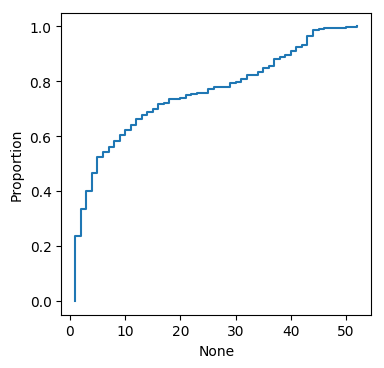

In [3]:
plt.figure(figsize=(4,4),dpi=100)
sns.ecdfplot(df.sum(1))

In [5]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

#--Getting similarities
jc_similarities = 1- pdist(df, 'jaccard')
df2 = pd.DataFrame(squareform(jc_similarities), index= df.index.values, columns=df.index.values)


/home/nkurzawa/miniconda3/envs/sign/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


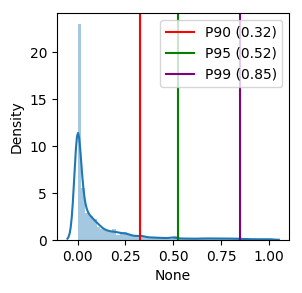

In [6]:
plt.figure(figsize=(3,3),dpi=100)
sns.distplot(jc_similarities)

colors = ['red','green','purple']
for pc, col in zip([90,95,99],colors):
    plt.axvline(np.percentile(jc_similarities, pc), label='P%i (%.2f)'%(pc,np.percentile(jc_similarities, pc)),
               color=col)
plt.legend()

In [7]:
#--Defining parameters for triplets
proportion = 0.05
n_neigh = int(df2.shape[0]*proportion)
min_jc = 0.1
high_jc = 0.52

N_triplets = 1000000
N_hard = 0.3
N_soft = 1-N_hard
#proporiton_uneffective = 0.25

n_trip = int(np.round(1000000*N_soft/df2.shape[0]))
n_hard_trip = int(np.round(1000000*N_hard/df2.shape[0]))
#n_trip_uneffective = int(np.round(n_trip*proporiton_uneffective))
#n_trip = int(n_trip - n_trip_uneffective)

In [8]:

dgs = np.array(df2.columns)
triplets = []
hard_triplets = {0:[],1:[],2:[]}
for ix,dg in tqdm(enumerate(df2.index.values), total=df2.shape[0]):
    _triplets = []
    _hard_triplets = {0:[],1:[],2:[]}
    
    #--Getting jaccard similarity  vector
    v = np.array(df2.iloc[ix])
    v[ix] = np.nan #masking itself
  
    #--Getting pos
    ixs = np.where(v >= high_jc)[0]
    if len(ixs) < n_neigh:
        ixs = np.argsort(v)[::-1]
        ixs = ixs[v[ixs] >= min_jc]
        if len(ixs) == 0: continue
        cutoff = v[ixs][min([n_neigh-1, len(ixs)-1])]
        ixs = v >= cutoff
        
    neighs = dgs[ixs]
    similarities = v[ixs]
    probs = similarities / np.sum(similarities)
    
    #--Getting negs
    negs = np.array(list(set(dgs)-set(neighs)))   
    
    #--Getting triplets
    
    #----Negs
    for _ in range(n_trip):
        _triplets.append([dg,np.random.choice(neighs,p=probs), np.random.choice(negs)])
    
    #----Uneffective
    #for _ in range(n_trip_uneffective):
    #    _triplets.append([dg,np.random.choice(neighs,p=probs), np.random.choice(uneffective)])
  
    #  for i, neg in enumerate(negs):
  #      if i-norm == len(neighs):
  #          norm+=len(neighs)
  #      pos = neighs[i-norm]
 # 
 #       _triplets.append([dg,pos,neg])
  
    triplets.extend(_triplets)
    
    #--Adding hard triplets
    scores = np.unique(similarities)
    cutoffs = np.unique([np.percentile(scores,pc) for pc in [0,25,50,75,100]]) #unique and sort
    labels = np.arange(len(cutoffs))[:-1]
    groups = np.array(pd.cut(similarities, cutoffs, labels=labels))
    labels = [x for x in labels if x in groups]

    if len(labels) > 1:
        n_subhard = int(np.ceil(n_hard_trip/(len(labels)-1)))

        hard_positives = neighs[groups == labels[-1]]
        hard_probs = similarities[groups == labels[-1]]
        hard_probs = hard_probs/np.sum(hard_probs)

        for i in range(len(labels)-1):
            hard_negatives =  neighs[groups == labels[i]]
            assert len(set(hard_negatives) & set(hard_positives)) == 0
            for _ in range(n_subhard):
                _hard_triplets[labels[i]].append([dg,np.random.choice(hard_positives, p=hard_probs), np.random.choice(hard_negatives)])
        
    hard_triplets[0].extend(_hard_triplets[0])
    hard_triplets[1].extend(_hard_triplets[1])
    hard_triplets[2].extend(_hard_triplets[2])
    
    
    #labels = [labels[0],labels[-1]] # Skiping Q2 and Q3, so the hard negative are Q1 and hard positives are Q4
    #for i in range(len(labels)-1):
    #    g1 = labels[i]
    #    g2 = labels[i+1]
    #    dg1 = dgs[ixs][groups==g1]
    #    dg2 = dgs[ixs][groups==g2]
    #    for hard_neg in dg1:
    #        for hard_pos in dg2:
    #            _hard_triplets.append([dg, hard_pos, hard_neg])
                

    #n_hard = int(len(_triplets)*proportion_hard_triplets)
    #hard_triplets.extend(np.random.permutation(_hard_triplets)[:n_hard])
    #hard_triplets.extend(np.rando,



  0%|          | 0/498 [00:00<?, ?it/s]

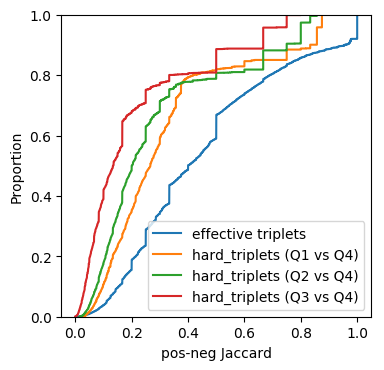

In [9]:
k = df2.melt(ignore_index=False).reset_index().values
pair2score = dict(zip(zip(k[:,0],k[:,1]), k[:,2]))

plt.figure(figsize=(4,4),dpi=100)

#--triplets
v = []
#v2 = []
for x in triplets:
    pos =  x[0],x[1]
    neg = x[0],x[2]
    if pos in pair2score:
        pos  = pair2score[pos]
    else:
        sys.exit()
        
    if neg in pair2score:
        neg = pair2score[neg]
        v.append(pos-neg)
    else:
        sys.exit()
        #neg = 0  
        #v2.append(pos-neg)
        
sns.ecdfplot(v, label='effective triplets')
#sns.ecdfplot(v2, label='uneffective triplets')

#--hard triplets
for g in hard_triplets:
    
    v2 = []
    for x in hard_triplets[g]:
        pos =  x[0],x[1]
        neg = x[0],x[2]
        if pos in pair2score:
            pos  = pair2score[pos]
        else:
            sys.exit()

        if neg in pair2score:
            neg = pair2score[neg]
        else:
            sys.exit()

        v2.append(pos-neg)
    
    sns.ecdfplot(v2, label='hard_triplets (Q%i vs Q4)'%(g+1))


plt.xlabel('pos-neg Jaccard')
plt.legend()

In [11]:
all_triplets = list(triplets)
for g in list(hard_triplets):
    all_triplets.extend(list(hard_triplets[g]))
all_triplets = np.array(all_triplets)

print('triplets: %i'%len(triplets))
_uneffective = set(uneffective)
easy = len([x for x in triplets if x[-1] in _uneffective])
print('\t--> effective: %i (%.2f)%%'%(len(triplets)-easy, (100*(len(triplets)-easy)/len(all_triplets))))
print('\t--> uneffective: %i (%.2f)%%'%(easy, 100*easy/len(all_triplets)))
total_hard = np.sum([len(hard_triplets[g]) for g in hard_triplets])
print('hard triplets: %i'%total_hard)
for g in hard_triplets:
    print('\t--> Q%i vs Q4: %i (%.2f)%%'%(g+1, len(hard_triplets[g]),100*len(hard_triplets[g])/len(all_triplets)))
print('all triplets: %i'%len(all_triplets))


triplets: 700188
	--> effective: 700188 (70.11)%
	--> uneffective: 0 (0.00)%
hard triplets: 298456
	--> Q1 vs Q4: 93666 (9.38)%
	--> Q2 vs Q4: 102696 (10.28)%
	--> Q3 vs Q4: 102094 (10.22)%
all triplets: 998644


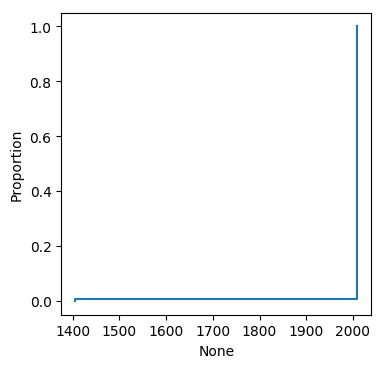

In [12]:
v = list(Counter(all_triplets[:,0]).values())

plt.figure(figsize=(4,4),dpi=100)
sns.ecdfplot(v)

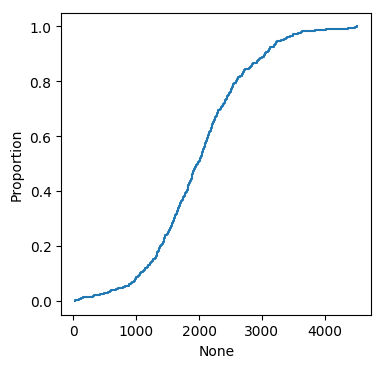

In [13]:
v = list(Counter(all_triplets[:,1]).values())

plt.figure(figsize=(4,4),dpi=100)
sns.ecdfplot(v)

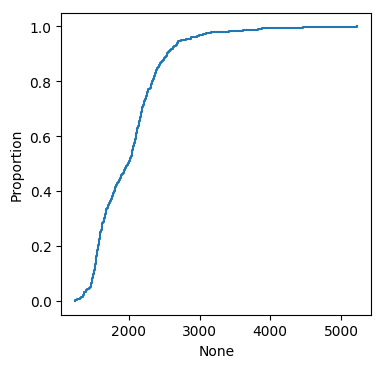

In [16]:
v = list(Counter(all_triplets[:,2]).values())

plt.figure(figsize=(4,4),dpi=100)
sns.ecdfplot(v)

/home/nkurzawa/miniconda3/envs/sign/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


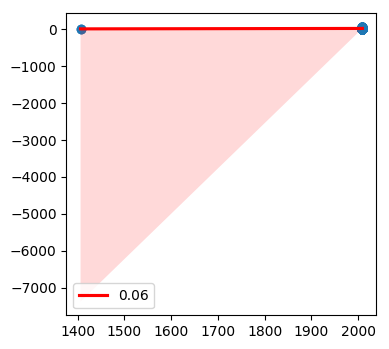

In [18]:
dg2sum = dict(df.sum(1))
dg2count = dict(Counter(all_triplets[:,0]))

x,y = [],[]

for dg in dg2sum:
    x.append(dg2sum[dg])
    y.append(dg2count[dg])
    
plt.figure(figsize=(4,4),dpi=100)
sns.regplot(y,x, line_kws={'color':'red', 'label':'%.2f'%(pearsonr(y,x)[0])})
plt.legend()

/home/nkurzawa/miniconda3/envs/sign/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


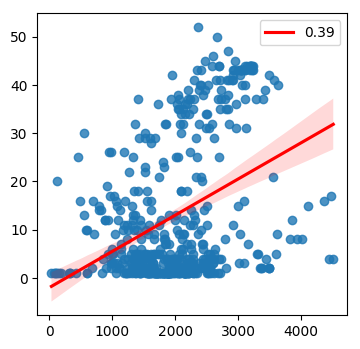

In [19]:
dg2sum = dict(df.sum(1))
dg2count = dict(Counter(all_triplets[:,1]))

x,y = [],[]

for dg in dg2sum:
    x.append(dg2sum[dg])
    y.append(dg2count[dg])
    
plt.figure(figsize=(4,4),dpi=100)
sns.regplot(y,x, line_kws={'color':'red', 'label':'%.2f'%(pearsonr(y,x)[0])})
plt.legend()

/home/nkurzawa/miniconda3/envs/sign/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


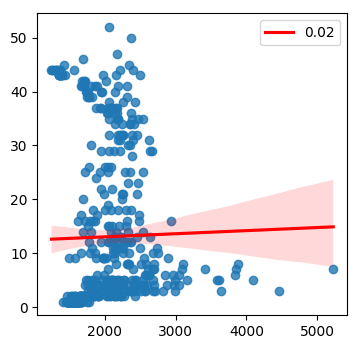

In [20]:
dg2sum = dict(df.sum(1))
dg2count = dict(Counter(all_triplets[:,2]))

x,y = [],[]

for dg in dg2sum:
    x.append(dg2sum[dg])
    y.append(dg2count[dg])
    
plt.figure(figsize=(4,4),dpi=100)
sns.regplot(y,x, line_kws={'color':'red', 'label':'%.2f'%(pearsonr(y,x)[0])})
plt.legend()

In [21]:
#Writing
all_triplets = pd.DataFrame(all_triplets, columns=['anchor','pos','neg']).sort_values(['anchor','pos','neg']).reset_index(drop=True)
all_triplets.to_csv('./maier_spitzer_fil_train_triplets.tsv.gz', sep='\t', index=False, compression='gzip')

In [22]:
all_triplets

,anchor,pos,neg
0,AADCDMQTJNYOSS-LBPRGKRZSA-N,BBAZDLONIUABKI-UHFFFAOYSA-N,AADCDMQTJNYOSS-LBPRGKRZSA-N
1,AADCDMQTJNYOSS-LBPRGKRZSA-N,BBAZDLONIUABKI-UHFFFAOYSA-N,AADCDMQTJNYOSS-LBPRGKRZSA-N
2,AADCDMQTJNYOSS-LBPRGKRZSA-N,BBAZDLONIUABKI-UHFFFAOYSA-N,ATALOFNDEOCMKK-BYYRLHKVSA-N
3,AADCDMQTJNYOSS-LBPRGKRZSA-N,BBAZDLONIUABKI-UHFFFAOYSA-N,BDYYDXJSHYEDGB-UHFFFAOYSA-N
4,AADCDMQTJNYOSS-LBPRGKRZSA-N,BBAZDLONIUABKI-UHFFFAOYSA-N,BFPYWIDHMRZLRN-SLHNCBLASA-N
...,...,...,...
998639,ZYSCHNVPUOSLNC-BTJKTKAUSA-N,YWKRLOSRDGPEJR-KIUKIJHYSA-N,XUBOMFCQGDBHNK-UHFFFAOYSA-N
998640,ZYSCHNVPUOSLNC-BTJKTKAUSA-N,YWKRLOSRDGPEJR-KIUKIJHYSA-N,XUFXOAAUWZOOIT-JMPDRRIHSA-N
998641,ZYSCHNVPUOSLNC-BTJKTKAUSA-N,YWKRLOSRDGPEJR-KIUKIJHYSA-N,YWXYYJSYQOXTPL-SLPGGIOYSA-N
998642,ZYSCHNVPUOSLNC-BTJKTKAUSA-N,YWKRLOSRDGPEJR-KIUKIJHYSA-N,ZGGHKIMDNBDHJB-RPQBTBOMSA-M
